# **Ejemplo de uso del framework TF Agents en Space Invaders**

# ** NO FUNCIONA: 5/4/2023
mirar: https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=0pTbJ3PeyF-u


In [1]:
# Instalar librerías
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

if COLAB:
  !sudo apt-get install -y xvfb ffmpeg
  !pip install -q 'gym==0.10.11'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q --upgrade tensorflow-probability
  !pip install -q tf-agents

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 780 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 xvfb amd64 2:1.20.13-1ubuntu1~20.04.8 [780 kB]
Fetched 780 kB in 1s (1,050 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to fr

In [3]:
!pip install ale-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.1 MB/s eta 0:00:00


In [ ]:
# Roms de Atari ya que Gym no provee las Roms
# ! wget http://www.atarimania.com/roms/Roms.rar
# ! mkdir /content/ROM/
# ! unrar e /content/Roms.rar /content/ROM/
# ! python -m atari_py.import_roms /content/ROM/

In [6]:
!pip3 install gym[atari,accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 KB 26.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 65.6 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.0-py3-none-any.whl size=446686 sha256=4e440cac26fc79b4f57eb304c560b313b400c20034ab6d27bd094b5fff8c6101
  Stored in directory: /root/.cache/pip/wheels/7d/17/c9/c31922a6aaf4ec7ec90eeee5dbc40ffbaafeda64b30a208b72
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.8.1
    Uninstalling ale-py-0.8.1:
      Successfully uninstalled ale-py-0.8.1


In [7]:
#### SI DA ERROR, REINICIAR ENTORNO Y SEGUIR EJECUTANDO ####

In [8]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, suite_atari, suite_atari_test
from tf_agents.environments import tf_py_environment, batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, network
from tf_agents.policies import random_tf_policy 
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

In [9]:
suite_atari_test.SuiteAtariTest()

<tf_agents.environments.suite_atari_test.SuiteAtariTest testMethod=runTest>

In [10]:
# VirtualDisplay para los entornos de gym
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [11]:
num_iterations = 50 #250000 

initial_collect_steps = 200  
collect_steps_per_iteration = 10 
replay_buffer_max_length = 100000

batch_size =   32
learning_rate = 2.5e-3
log_interval =   5000

num_eval_episodes = 5  
eval_interval = 25000

In [13]:
#env_name = 'Breakout-v4'
#env_name = 'Pong-v0'
#env_name = 'BreakoutDeterministic-v4'
env_name = 'SpaceInvaders-v4'


# AtariPreprocessing runs 4 frames at a time, max-pooling over the last 2
# frames. We need to account for this when computing things like update
# intervals.
ATARI_FRAME_SKIP = 4

max_episode_frames=108000  # ALE frames

# Ejemplo de lectura de el entorno
env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

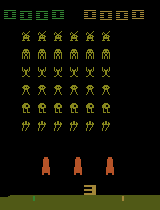

In [14]:
# Imágen de cómo empieza el juego 
env.reset()
PIL.Image.fromarray(env.render())

In [15]:
# Entornos de entrenamiento y validación de TF Agents
train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [16]:
# AtariPreprocessing corre 4 frames al mismo tiempo, max-pooling sobre los últimos 2 frames. 
# Habrá que tenerlo en cuenta al actualizar intervalos
ATARI_FRAME_SKIP = 4

class AtariCategoricalQNetwork(network.Network):
  """CategoricalQNetwork subclass that divides observations by 255."""

  def __init__(self, input_tensor_spec, action_spec, **kwargs):
    super(AtariCategoricalQNetwork, self).__init__(
        input_tensor_spec, state_spec=())
    input_tensor_spec = tf.TensorSpec(
        dtype=tf.float32, shape=input_tensor_spec.shape)
    self._categorical_q_network = categorical_q_network.CategoricalQNetwork(
        input_tensor_spec, action_spec, **kwargs)

  @property
  def num_atoms(self):
    return self._categorical_q_network.num_atoms

  def call(self, observation, step_type=None, network_state=()):
    state = tf.cast(observation, tf.float32)
    # We divide the grayscale pixel values by 255 here rather than storing
    # normalized values beause uint8s are 4x cheaper to store than float32s.
    # TODO(b/129805821): handle the division by 255 for train_eval_atari.py in
    # a preprocessing layer instead.
    state = state / 255
    return self._categorical_q_network(
        state, step_type=step_type, network_state=network_state)

In [17]:
fc_layer_params = (512,)
conv_layer_params=((32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1))

q_net = AtariCategoricalQNetwork(
            train_env.observation_spec(),
            train_env.action_spec(),
            conv_layer_params=conv_layer_params,
            fc_layer_params=fc_layer_params)

In [18]:
optimizer = tf.compat.v1.train.RMSPropOptimizer(
    learning_rate=learning_rate,
    decay=0.95,
    momentum=0.0,
    epsilon=0.00001,
    centered=True)

train_step_counter = tf.Variable(0)

observation_spec = tensor_spec.from_spec(train_env.observation_spec())
time_step_spec = ts.time_step_spec(observation_spec)

action_spec = tensor_spec.from_spec(train_env.action_spec())
target_update_period=32000  # ALE frames
update_period=16  # ALE frames
_update_period = update_period / ATARI_FRAME_SKIP


agent = categorical_dqn_agent.CategoricalDqnAgent(
    time_step_spec,
    action_spec,
    categorical_q_network=q_net,
    optimizer=optimizer,
    #epsilon_greedy=epsilon,   # Probar 
    n_step_update=1.0,
    target_update_tau=1.0,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period),
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False)

# DQN Agent: Se pueden usar ambos, el Categorical me ha dado mejores resultados.
"""
agent = dqn_agent.DqnAgent(
    time_step_spec,
    action_spec,
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy=0.01,
    n_step_update=1.0,
    target_update_tau=1.0,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period),
    td_errors_loss_fn=common.element_wise_huber_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=_global_step)
"""


agent.initialize()

In [19]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


In [20]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# Dataset genera trayectorias con shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [21]:
# Política random para el video de comparación
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, \
             steps=initial_collect_steps)

# Aquí está la magia (donde se entrena el modelo)

In [22]:
# Entrenamos
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph 
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, \
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, \
                                    num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

AttributeError: ignored

In [ ]:

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=10)

In [ ]:
# Funciones para ver los videos en Colab y guardarlos.
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [ ]:
create_policy_eval_video(agent.policy, "Modelo-entrenado")

In [ ]:
create_policy_eval_video(random_policy, "Modelo-politica-random")